In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')

# 1

In [2]:
beta = lambda x, y: np.dot(np.dot(np.linalg.inv(x.T.dot(x)), x.T), y)
predict = lambda x, b: x.dot(b)

In [3]:
noisysine = pd.read_csv('../data/noisysine.csv')
hydrodynamics = pd.read_csv('../data/hydrodynamics.csv')

In [4]:
def plot_regression(x, y, b):
    plt.figure(figsize=(10, 5))
    plt.scatter(x[:, 1], y)
    x_axis = np.linspace(x[:, 1].min(), x[:, 1].max(), len(x))
    y = 0

    for i in range(len(b)):
        y += b[i] * x_axis ** i
        
    plt.plot(x_axis, y, color='red') 
    plt.show()

In [15]:
def regression(data, y, power, label='y', plot=False, b_ridge=False, verbose=False, lasso=False):
    for p in range(1, power + 1):
        pf = PolynomialFeatures(p)
        x = pf.fit_transform(data)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        if b_ridge:
            r, b = ridge(x_train, y_train, verbose=verbose)
            print(f'Ridge = {r}')
        elif lasso:
            model = Lasso()
            distributions = dict(alpha=np.arange(0, 3, 0.005))
            lcv = RandomizedSearchCV(model, distributions, cv=3).fit(x, y)
            b = lcv.best_estimator_.coef_
            print(f'Использовано признаков {len(b[b != 0])} / {len(b)}')
        else:
            b = beta(x_train, y_train)
        
        print(f'R^2 для степени {p}')
        
        y_pred = predict(x_test, b)
        print(f'\tвалидация: {r2_score(y_test, y_pred):.3f}')
        if not lasso:
            y_pred = predict(x_train, b)
            print(f'\tобучающий набор: {r2_score(y_train, y_pred):.3f}')

        if plot:
            plot_regression(x_test, y_test, b)

R^2 для степени 1
	валидация: -0.800
	обучающий набор: 0.218


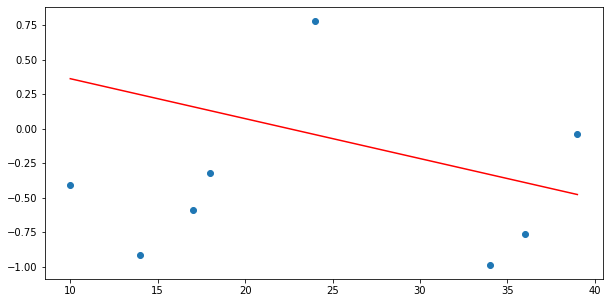

R^2 для степени 2
	валидация: -0.007
	обучающий набор: 0.202


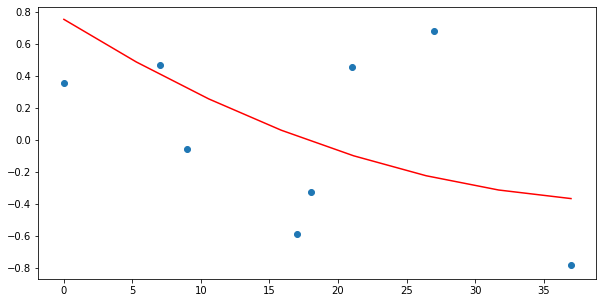

R^2 для степени 3
	валидация: 0.164
	обучающий набор: 0.202


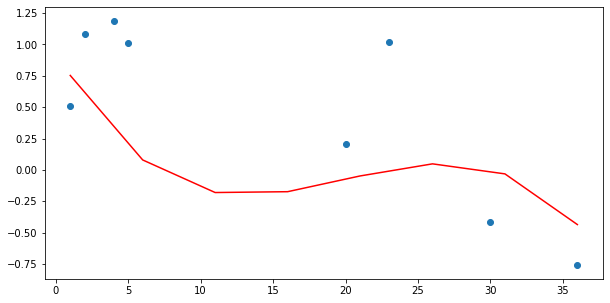

R^2 для степени 4
	валидация: 0.399
	обучающий набор: 0.283


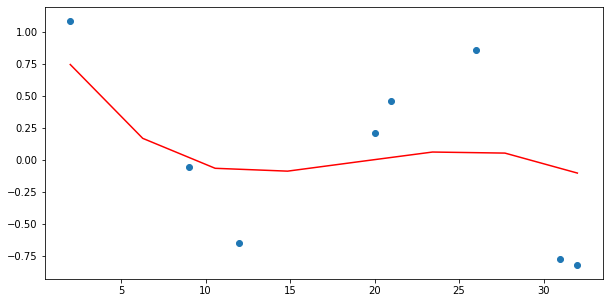

R^2 для степени 5
	валидация: 0.895
	обучающий набор: 0.892


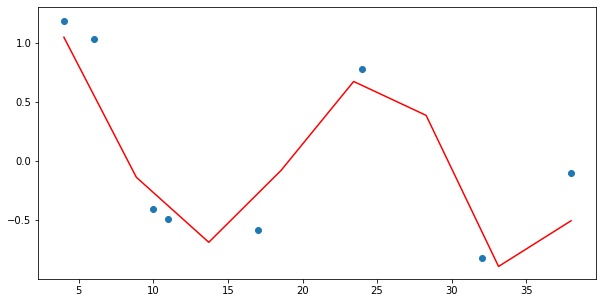

In [6]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True)

In [7]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2)

R^2 для степени 1
	валидация: 0.648
	обучающий набор: 0.659
R^2 для степени 2
	валидация: 0.927
	обучающий набор: 0.928


# 2

In [8]:
def delta(r, b, x, t, s):
    xTxprt = x.T.dot(x) + r * t
    sqared = np.linalg.inv(xTxprt)
    inv_sqared = sqared.dot(sqared)
    return (r ** 2 * b.T).dot(inv_sqared).dot(b) + s * np.trace(x.dot(inv_sqared).dot(x.T))

def ridge(x, y, eps=0.00001, n_iter=1000, verbose=False):
    n = len(x)
    m = x.shape[1]
    t = np.eye(m, m)
    beta = lambda x, y, t: np.linalg.inv(x.T.dot(x) + r * t).dot(x.T).dot(y)

    errors = lambda x, y, b: y - x.dot(b)

    s2 = lambda errors, n, m: errors.T.dot(errors) / (n - m)

    r = 0
    i = 0
    while True:
        b = beta(x, y, t)
        
        e = errors(x, y, b)
        s = s2(e, n, m)
        r_old = r
        r = optimize.minimize(delta, [0.], args=(b, x, t, s)).x
        if verbose:
            print(f'Candidate r = {r}')
        i += 1
        if np.abs(r - r_old) <= eps or i == n_iter:
            break
    return r, b

Ridge = [2.28921208]
R^2 для степени 1
	валидация: 0.068
	обучающий набор: 0.201


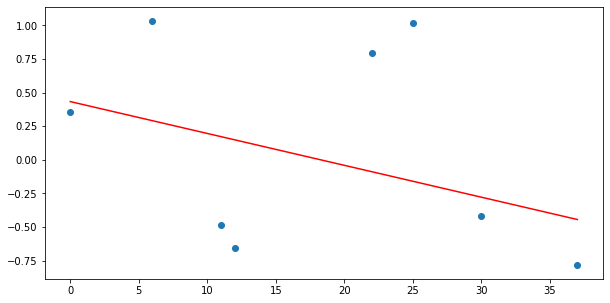

Ridge = [76.7350976]
R^2 для степени 2
	валидация: 0.019
	обучающий набор: 0.132


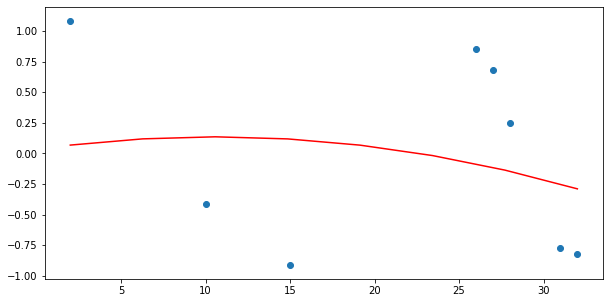

Ridge = [0.57793668]
R^2 для степени 3
	валидация: 0.296
	обучающий набор: 0.278


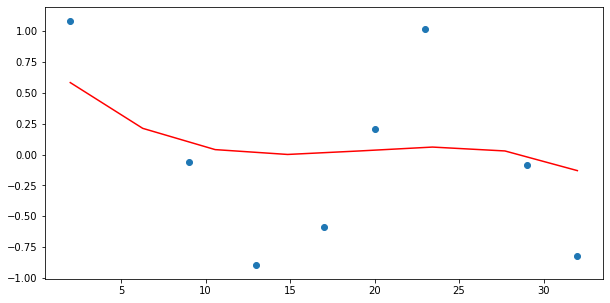

Ridge = [0.36061841]
R^2 для степени 4
	валидация: -0.041
	обучающий набор: 0.339


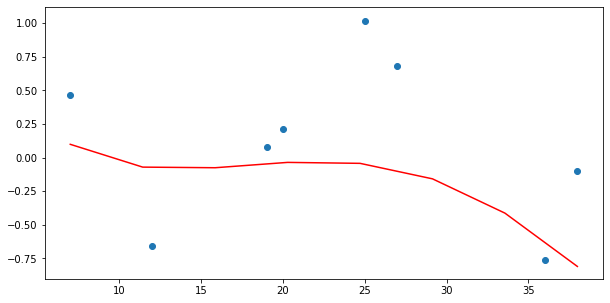

Ridge = [1.88800155]
R^2 для степени 5
	валидация: 0.918
	обучающий набор: 0.880


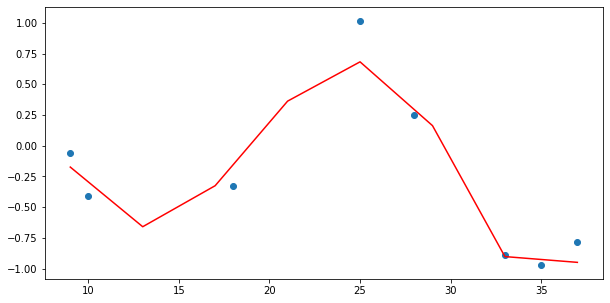

In [9]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True, b_ridge=True)

In [10]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2, b_ridge=True)

Ridge = [-0.13477311]
R^2 для степени 1
	валидация: 0.679
	обучающий набор: 0.640
Ridge = [0.00015377]
R^2 для степени 2
	валидация: 0.901
	обучающий набор: 0.933


# 3

Использовано признаков 1 / 2
R^2 для степени 1
	валидация: -0.133


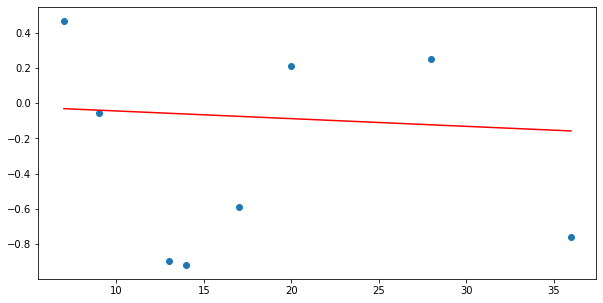

Использовано признаков 1 / 3
R^2 для степени 2
	валидация: 0.120


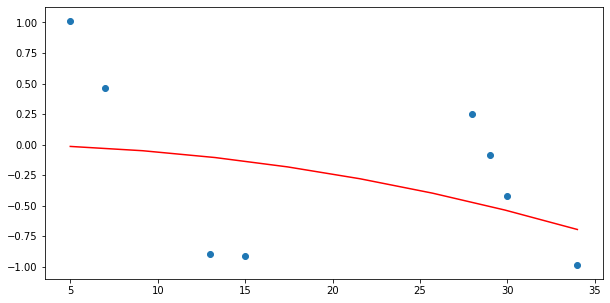

Использовано признаков 2 / 4
R^2 для степени 3
	валидация: -0.551


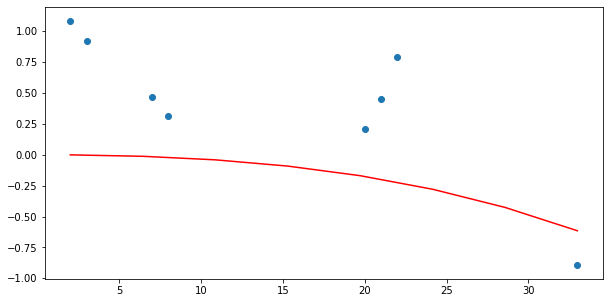

Использовано признаков 3 / 5
R^2 для степени 4
	валидация: 0.006


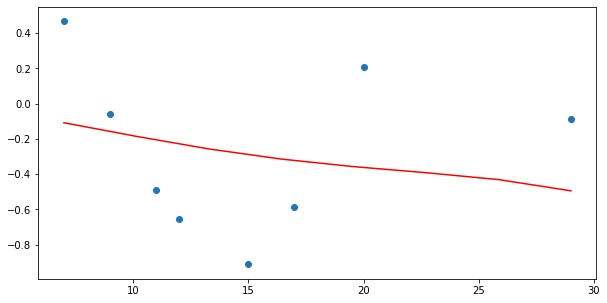

Использовано признаков 4 / 6
R^2 для степени 5
	валидация: 0.162


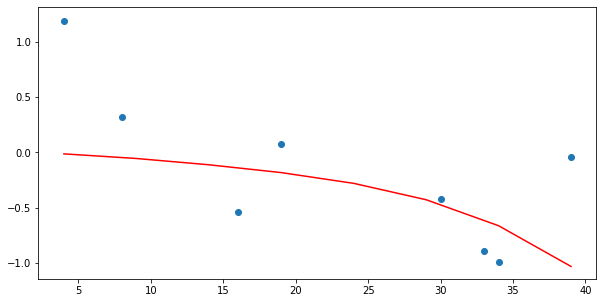

In [16]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True, lasso=True)

In [18]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2, lasso=True)

Использовано признаков 1 / 7
R^2 для степени 1
	валидация: 0.250
Использовано признаков 12 / 28
R^2 для степени 2
	валидация: 0.339
